In [1]:
import os
import sys
import string
import random
import torch
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import scipy.stats as stats
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torch import optim
from typing import Optional
from ignite.metrics import IoU
from PIL import Image, ImageOps, ImageFilter
from albumentations import transforms, Compose
from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer, LightningDataModule, LightningModule

warnings.filterwarnings("ignore")

In [2]:
# open file and read data
file = open("Pascal-part/train_id.txt", "r")
train_ids = file.read()
train_ids = train_ids.split("\n")
file.close()

file = open("Pascal-part/val_id.txt", "r")
val_ids = file.read()
val_ids = val_ids.split("\n")
file.close()

file = open("Pascal-part/classes.txt", "r")
classes = file.read()
classes = classes.split("\n")
file.close()
classes = [x.split(":") for x in classes]
# convert list to dictionary
classes = dict(classes)

Shape of train image: (500, 375)
Shape of val image: (333, 500)
Shape of train mask: (375, 500)
Shape of val mask: (500, 333)
Classes in train mask: [0 1 2 3 4 5 6]
Classes in val mask: [0 1 2 3 4 5 6]


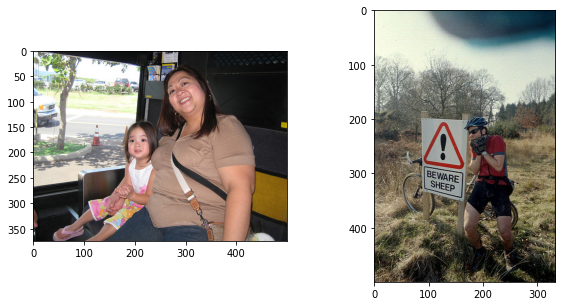

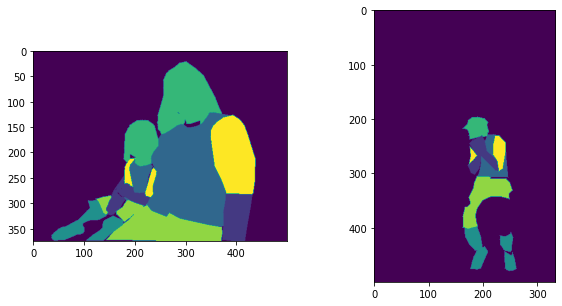

In [3]:
# a function to get the mask
def get_mask(id):
    mask = np.load(f"Pascal-part/gt_masks/{id}.npy", mmap_mode="r")
    return mask

# a function to get the image
def get_image(id):
    # read image
    image = Image.open(f"Pascal-part/JPEGImages/{id}.jpg")
    return image

# extract the mask and image from random train and val
# get the random train and val id
train_id = random.choice(train_ids)
val_id = random.choice(val_ids)

train_mask = get_mask(train_id)
train_image = get_image(train_id)
val_mask = get_mask(val_id)
val_image = get_image(val_id)

# show the train and val image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
print(f"Shape of train image: {train_image.size}\nShape of val image: {val_image.size}")
ax[0].imshow(train_image)
ax[1].imshow(val_image)

# show the train and val mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
print(f"Shape of train mask: {train_mask.shape}\nShape of val mask: {val_mask.shape}")
ax[0].imshow(train_mask)
ax[1].imshow(val_mask)

# a function to extract from mask the classes
def get_classes(mask):
    # get the unique classes
    classes = np.unique(mask)
    return classes

# get the classes from the train and val mask
train_classes = get_classes(train_mask)
val_classes = get_classes(val_mask)
print(f"Classes in train mask: {train_classes}\nClasses in val mask: {val_classes}")


In [4]:
# create the dataset class for the segmentation task
class PascalDatasetSegmentation(torch.utils.data.Dataset):
    def __init__(self, ids, transform=None):
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        # get the id
        id = self.ids[index]
        # get the mask
        mask = get_mask(id)
        # get the image
        image = get_image(id)
        # convert the image to numpy array
        image = np.array(image)
        # convert the mask to numpy array
        mask = np.array(mask)
        # convert the image to tensor
        image = torch.from_numpy(image)
        # convert the mask to tensor
        mask = torch.from_numpy(mask)
        # convert the image to float
        image = image.float()
        # convert the mask to long
        mask = mask.long()
        # add the channel dimension
        image = image.unsqueeze(0)
        # add the channel dimension
        mask = mask.unsqueeze(0)
        # return the image and mask
        return image, mask

In [5]:
# create the dataset class for the segmentation task using pytorch lightning
class PascalSegmentation(LightningDataModule):
    def __init__(self, data_dir:string="Pascal-part", batch_size:int=32, transform=None):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transform


    def prepare_data(self):
        # download the data
        pass

    def setup(self, stage:Optional[str]=None):
        if stage 
        # get the train and val ids
        file = open(f"{self.data_dir}/train_id.txt", "r")
        train_ids = file.read()
        train_ids = train_ids.split("\n")
        file.close()

        file = open(f"{self.data_dir}/val_id.txt", "r")
        val_ids = file.read()
        val_ids = val_ids.split("\n")
        file.close()

        # get the train and val dataset
        self.train_dataset = PascalDataset(train_ids, self.data_dir)
        self.val_dataset = PascalDataset(val_ids, self.data_dir)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4
        )

SyntaxError: invalid syntax (4089128038.py, line 15)

In [35]:
# create a LightningModule for the segmentation task
class PascalSegmentationModel(LightningModule):
    def __init__(self, classes=21):
        super().__init__()
        # create the model
        self.model = torch.hub.load(
            "pytorch/vision:v0.6.0", "deeplabv3_resnet101", pretrained=True
        )
        # get the number of input features of the classifier
        num_ftrs = self.model.classifier[4].in_channels
        # replace the last layer with the number of classes
        self.model.classifier[4] = torch.nn.Conv2d(num_ftrs, classes, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # get the image and mask
        image, mask = batch
        # get the output
        output = self(image)
        # calculate the loss
        loss = F.cross_entropy(output, mask)
        # log the loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # get the image and mask
        image, mask = batch
        # get the output
        output = self(image)
        # calculate the loss
        loss = F.cross_entropy(output, mask)
        # log the loss
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer